<a href="https://colab.research.google.com/github/iambaangkok/261459-Deep-Learning/blob/master/Eye_Diseases_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
%reset -f

from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iambaangkok","key":"4dc0b759a44f63015879dfef976d16d1"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets list

In [ ]:
! kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

 97% 716M/736M [00:21<00:00, 21.8MB/s]
100% 736M/736M [00:21<00:00, 36.3MB/s]


In [ ]:
! unzip eye-diseases-classification.zip

# Split data into train - test

In [ ]:
import os
import numpy as np
import shutil

In [ ]:
# # Creating Train / Val / Test folders (One time use)
root_dir = 'dataset'
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

for cls in classes:
  os.makedirs(root_dir +'/train/' + cls)
  os.makedirs(root_dir +'/val/' + cls)
  os.makedirs(root_dir +'/test/' + cls)
  

In [ ]:
# Creating partitions of the data after shuffeling
def loadDataset(currentCls):
  src = "dataset/"+currentCls # Folder to copy images from

  train_ratio = 0.7
  val_ratio = 0.15
  test_ratio = 0.15

  allFileNames = os.listdir(src)
  np.random.shuffle(allFileNames)
  train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                            [int(len(allFileNames)*(1 - (val_ratio + test_ratio))), 
                                                            int(len(allFileNames)*(1 - val_ratio))])


  train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
  test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

  print('Total images: ', len(allFileNames))
  print('Training: ', len(train_FileNames))
  print('Validation: ', len(val_FileNames))
  print('Testing: ', len(test_FileNames))

  # Copy-pasting images
  for name in train_FileNames:
      shutil.copy(name, "dataset/train/"+currentCls)

  for name in val_FileNames:
      shutil.copy(name, "dataset/val/"+currentCls)

  for name in test_FileNames:
      shutil.copy(name, "dataset/test/"+currentCls)

In [ ]:
loadDataset('cataract')

Total images:  1038
Training:  726
Validation:  156
Testing:  156


In [ ]:
loadDataset('diabetic_retinopathy')
loadDataset('glaucoma')
loadDataset('normal')

Total images:  1098
Training:  768
Validation:  165
Testing:  165
Total images:  1007
Training:  704
Validation:  151
Testing:  152
Total images:  1074
Training:  751
Validation:  161
Testing:  162


# Load data into DataLoader

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torchvision

from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

## Preprocessing pipeline

`torchvision.transforms.Compose` is data preprocesssing pipeline

In [ ]:
batch_size = 128

# PREPROCESSING PIPELINE
transform = torchvision.transforms.Compose([ 
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Resize((256,256))
                  #torchvision.transforms.Normalize(256/2,127)
])

ds_train = "dataset/train"
ds_val = "dataset/val"
ds_test  = "dataset/test"

ds_train = ImageFolder(root=ds_train, transform=transform)
ds_val = ImageFolder(root=ds_val, transform=transform)
ds_test = ImageFolder(root=ds_test, transform=transform)
                                    
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val   = DataLoader(ds_val, batch_size=batch_size)
dl_test  = DataLoader(ds_test, batch_size=batch_size)

## Sample images

In [ ]:
labels_map = {
    0: "cataract",
    1: "diabetic_retinopathy",
    2: "glaucoma",
    3: "normal",
}

rgb_map = {
    0: "R",
    1: "G",
    2: "B",
}

Define sampleImage()

In [ ]:
def sampleImage(img_count = 1, split_channel = False, width = 15, height = 15):
  if split_channel:
    fig, ax = plt.subplots(img_count,3,figsize=(height,width))
    for j in range(0,img_count):
      sample_idx = torch.randint(len(ds_train), size=(1,)).item()
      img, label = ds_train[sample_idx]
      imgs = []
      for i in range(0,3):
        imgs.append(img.permute([1,2,0])[:,:,i])
        if img_count == 1:
          ax[i].imshow(imgs[i], cmap='viridis'), ax[i].set_title(f"{sample_idx} {labels_map[label]} {rgb_map[i%3]} \nmax= {str(imgs[0].max().item())} \nmin= + {str(imgs[0].min().item())}", fontsize=16)
        else:
          ax[j][i].imshow(imgs[i], cmap='viridis'), ax[j][i].set_title(f"{sample_idx} {labels_map[label]} {rgb_map[i%3]} \nmax= {str(imgs[0].max().item())} \nmin= + {str(imgs[0].min().item())}", fontsize=16)
  else:
    nRows = int((img_count-1)/3+1)
    fig, ax = plt.subplots(nRows,3,figsize=(height,width))
    for i in range(0,nRows*3):
        sample_idx = torch.randint(len(ds_train), size=(1,)).item()
        img, label = ds_train[sample_idx]
        img = img.permute([1,2,0])
        if img_count <= 3:
          if i >= img_count:
            ax[i].axis("off")
          else:
            ax[i].imshow(img, cmap='viridis'), ax[i].set_title(f"{sample_idx} {labels_map[label]} RGB \nmax= {str(img.max().item())} \nmin= + {str(img.min().item())}", fontsize=16)
        else:
          if i >= img_count:
            ax[int(i/3)][i%3].axis("off")
          else:
            ax[int(i/3)][i%3].imshow(img, cmap='viridis'), ax[int(i/3)][i%3].set_title(f"{sample_idx} {labels_map[label]} RGB \nmax= {str(img.max().item())} \nmin= + {str(img.min().item())}", fontsize=16)
          

    # fig, ax = plt.subplots(1,1,figsize=(height,width))
    # ax.imshow(img.permute([1,2,0]))
    # ax.set_title(f"{sample_idx} {labels_map[label]} RGB \nmax= {str(img.max().item())} \nmin= + {str(img.min().item())}", fontsize=16)

Sample images: RGB

> result is best when imgCount is divisible by 3

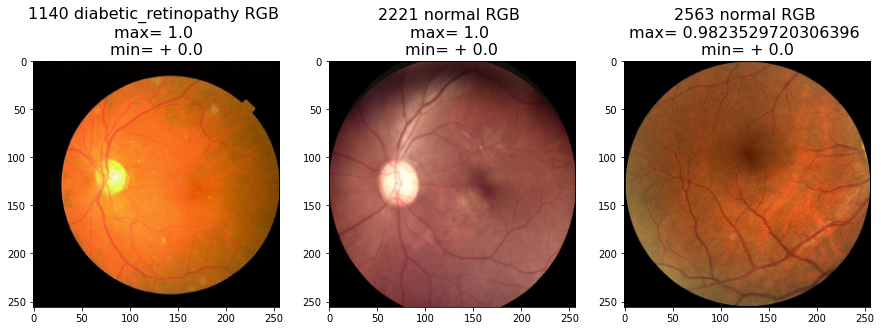

In [ ]:
sampleImage(3)

Sample images: split channel

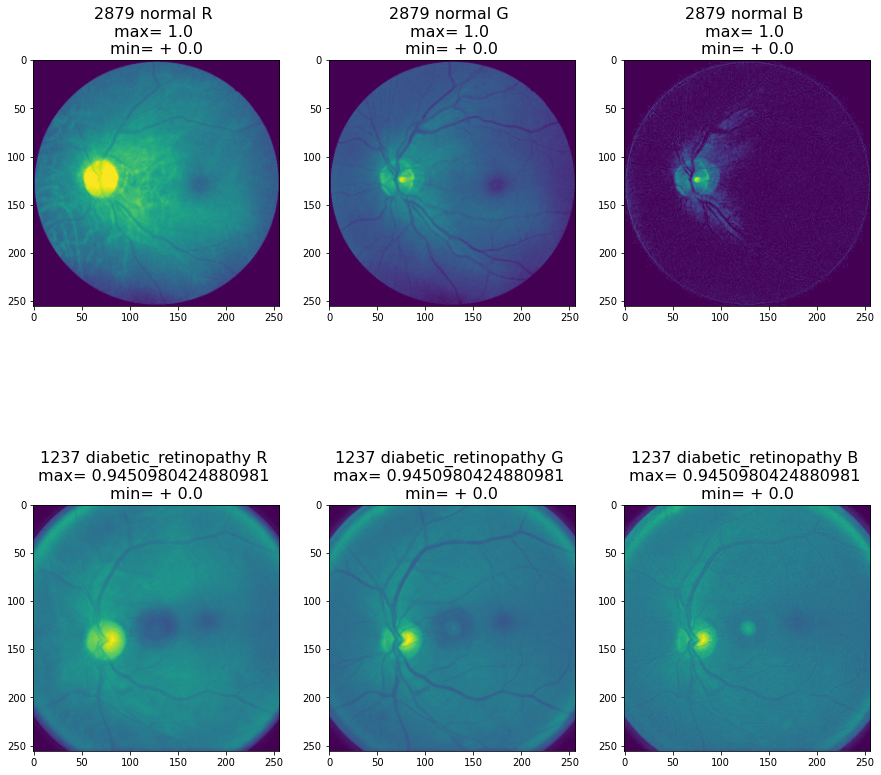

In [ ]:
sampleImage(2, split_channel=True)

# Create the model

> parameters are automatically randomized everytime a model is created

Pretrained model

In [ ]:
# from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
# model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

In [ ]:
# print(model)

In [ ]:
# model(torch.zeros(1024,3,227,227)).size()

Custom model

pytorch lightning erly stopping and more functions

cross validation


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

model = nn.Sequential(
    
    nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=2),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),

    nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),

    nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),

    nn.Conv2d(128, 64, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),

    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(64, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 4),

    nn.LogSoftmax(1)
)

model(torch.zeros(128,3,256,256)).size()

torch.Size([128, 4])

## Loading trained model

### Entire model

In [ ]:
# torch.save(model, 'entire_model.pth')

In [ ]:
# model= torch.load('entire_model.pth')

### Just parameters

In [ ]:
LOAD_PARAM = False
MODEL_NUM = 1
PARAM_NUM = 9
if LOAD_PARAM:
  paramload = f'saved_param/model_{MODEL_NUM}/model_{MODEL_NUM}param_{PARAM_NUM}.pth'
  model.load_state_dict(torch.load(paramload))

In [ ]:
params = list(model.named_parameters())
name, param = params[0]
# if param.requires_grad: 
  # print(name, param.data)

## Select loss function & optimizer

In [ ]:
# nn.CrossEntropyLoss = nn.LogSoftmax + `nn.NLLLoss
loss_fn = nn.CrossEntropyLoss()  # 
optimizer = optim.Adam( model.parameters(), lr=0.001 )

# Train the model
With accuracy from testing with val and test

Define validate() for easier use

In [ ]:
def validate():

  val_loss = 0.0

  model.eval()
  val_correct = 0
  with torch.no_grad():
    for x, y in dl_val:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            #y_onehot = nn.functional.one_hot(y, num_classes=10).float()  

            y_predict = model(x)                    
            loss = loss_fn(y_predict, y)

            val_loss += loss.item()

            pred = y_predict.argmax(dim=1, keepdim=True)  
            val_correct += pred.eq(y.view_as(pred)).sum().item()
            
  print(f'\t Valid loss: {val_loss/len(dl_val):8.5f}, Valid acc: {100*val_correct/len(dl_val.dataset):6.2f}%') 

In [ ]:
num_epoch = 10
model = model.to('cuda:0')

SAVE_PARAMS = True
MODEL_NUM = 2
STARTING_EPOCH = 0

training_now = str(MODEL_NUM) 
save_path = 'saved_param/model_'+training_now
if(not os.path.exists(save_path)):
  os.makedirs(save_path)


for epoch in range(num_epoch):
    trn_loss = 0.0    
    correct, val_correct = 0, 0

    model.train()    
    for i,(x, y) in enumerate(dl_train):
        x, y = x.to('cuda:0'), y.to('cuda:0')
        
        optimizer.zero_grad()
        y_predict = model(x)        
        loss = loss_fn(y_predict, y)
        loss.backward()
        optimizer.step()
        
        trn_loss += loss.item()

        pred = y_predict.argmax(dim=1, keepdim=True)          
        correct += pred.eq(y.view_as(pred)).sum().item()
        if(i%10 == 0):
          print(f'Epoch {epoch} Batch {i}: loss: {loss}')            

    # Save model to file    
    if SAVE_PARAMS:
      torch.save(model.state_dict(), 'saved_param/model_'+training_now+'/model_'+training_now+'param_'+str(epoch+STARTING_EPOCH)+'.pth')
    print(f'Epoch {epoch}: Train loss: {trn_loss/len(dl_train):8.5f}, Train acc: {100*correct/len(dl_train.dataset):6.2f}%')

    validate()       

Epoch 0 Batch 0: loss: 0.907805323600769
Epoch 0 Batch 10: loss: 0.948853611946106
Epoch 0 Batch 20: loss: 0.9788228869438171
Epoch 0: Train loss:  0.96176, Train acc:  79.42%
	 Valid loss:  1.02883, Valid acc:  69.35%
Epoch 1 Batch 0: loss: 0.9477666616439819
Epoch 1 Batch 10: loss: 1.0937705039978027
Epoch 1 Batch 20: loss: 0.9934654831886292
Epoch 1: Train loss:  1.06021, Train acc:  67.31%
	 Valid loss:  1.03310, Valid acc:  70.30%
Epoch 2 Batch 0: loss: 1.1106184720993042
Epoch 2 Batch 10: loss: 0.936027467250824
Epoch 2 Batch 20: loss: 0.9805505275726318
Epoch 2: Train loss:  0.98927, Train acc:  75.31%
	 Valid loss:  1.00540, Valid acc:  74.25%
Epoch 3 Batch 0: loss: 1.0188966989517212
Epoch 3 Batch 10: loss: 0.9094446897506714
Epoch 3 Batch 20: loss: 0.9153668880462646
Epoch 3: Train loss:  0.95084, Train acc:  78.74%
	 Valid loss:  0.97955, Valid acc:  75.83%
Epoch 4 Batch 0: loss: 0.9666349291801453
Epoch 4 Batch 10: loss: 0.9886998534202576
Epoch 4 Batch 20: loss: 0.98070609

## Validation & Test


In [ ]:
validate()

	 Valid loss:  0.46442, Valid acc:  79.78%


In [ ]:
def testWithTestData():

  test_loss = 0.0

  model.eval()
  test_correct = 0
  with torch.no_grad():
    for x, y in dl_test:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            #y_onehot = nn.functional.one_hot(y, num_classes=10).float()  

            y_predict = model(x)                    
            loss = loss_fn(y_predict, y)

            test_loss += loss.item()

            pred = y_predict.argmax(dim=1, keepdim=True)  
            test_correct += pred.eq(y.view_as(pred)).sum().item()
            
  print(f'\t Test loss: {test_loss/len(dl_val):8.5f}, Test acc: {100*test_correct/len(dl_test.dataset):6.2f}%') 

In [ ]:
testWithTestData()

	 Test loss:  0.91675, Test acc:  82.05%
